# Trabajo Práctico 2 - Agentes

In [2]:
# Librerías
from pinecone import Pinecone, ServerlessSpec
from groq import Groq
import os
from sentence_transformers import SentenceTransformer
import torch
#from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from dotenv import load_dotenv
from tqdm.auto import tqdm
import re

In [3]:
# Selección del device
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"\nDevice: {device}") 


Device: mps


In [4]:
# Cargar las keys del archivo .env
load_dotenv()

True

## Diagrama

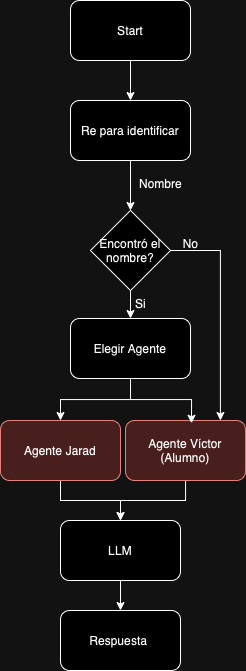

## Conversión de CVs a embeddings y cargarlos a Pinecone

In [5]:
# Configurar clave de API de Pinecone
PINECONE_API_KEY = os.getenv("pinecone_api_key")
pc = Pinecone(api_key=PINECONE_API_KEY)
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

# Configuración del modelo de embedding
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

# Lee documentos
def read_doc(directory):
    """
    Lee el documento PDF.
    """
    file_loader=PyPDFLoader(directory)
    documents = file_loader.load()
    return documents

# Convierte en chunks el documento
def chunk_documents(documents, chunk_size=205, chunk_overlap=45): #75/15
    """
    Crea chunks del documento.
    """
    text_splitter = CharacterTextSplitter(
        separator=" ", # Divide por espacios
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = []
    for doc in documents:
        # Divide el contenido del texto en fragmentos
        for chunk in text_splitter.split_text(doc.page_content): 
            chunks.append({
                "text": chunk,
                "metadata": doc.metadata #  # Mantén la fuente original
            })
    return chunks

# Procesar documentos y generar embeddings
def process_docs(documents):
    """
    Procesa el documento.
    """
    texts = [doc['text'] for doc in documents]
    embeddings = embed_model.encode(texts, convert_to_tensor=False, show_progress_bar=True)
    return texts, embeddings

# Función para inicializar un índice en Pinecone
def initialize_index(index_name):
    """
    Inicializa el índice.
    """
    if index_name not in pc.list_indexes():
        pc.create_index(
            name=index_name,
            dimension=384,
            metric="cosine",
            spec=spec
        )
    return pc.Index(index_name)

# Función para subir embeddings a un índice
def upload_embeddings_to_index(index, documents):
    """
    Carga los embeddings según el índice
    """
    texts, embeddings = process_docs(documents)
    ids = [f"doc_{i}" for i in range(len(texts))]
    vectors = [{"id": doc_id, "values": emb, "metadata": {"text": text}}
               for doc_id, emb, text in zip(ids, embeddings, texts)]
    
    batch_size = 5
    for i in tqdm(range(0, len(vectors), batch_size)):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch)

    print(f"\nGenerados {len(embeddings)} embeddings.")

# Eliminar índices anteriormente creados
pc.delete_index("victor-cv")
pc.delete_index("jarad-cv")

# Crear índices para cada persona
indices = {
    "victor": initialize_index("victor-cv"),
    "jarad": initialize_index("jarad-cv")
}

# Leer y dividir documentos para cada persona
cv_victor = read_doc("../../data/Silva_Victor_CV.pdf")
cv_jarad = read_doc("../../data/Jarad_Vod_Savo_CV.pdf")

# Separar en chunks los documentos
chunked_cv_victor = chunk_documents(cv_victor)
chunked_cv_jarad = chunk_documents(cv_jarad)

# Subir documentos a los índices correspondientes
upload_embeddings_to_index(indices["victor"], chunked_cv_victor)
upload_embeddings_to_index(indices["jarad"], chunked_cv_jarad)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Generados 14 embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Generados 12 embeddings.


## Creación de Agentes

In [6]:
# Configurar Groq
GROQ_API_KEY = os.getenv("groq_api_key")
groq_client = Groq(api_key=GROQ_API_KEY)

def create_prompt(query, pinecone_matches):
    """
    Crea un prompt para Groq utilizando la consulta y los documentos relevantes.
    """
    context = "\n".join([match["metadata"]["text"] for match in pinecone_matches])
    prompt = f"""
    Contexto relevante:
    {context}

    Pregunta:
    {query}

    Responde con información relevante al contexto y de forma concisa:
    """
    return prompt

def ask_groq(client, prompt, model="llama3-8b-8192"):
    """
    Envía el prompt a Groq y devuelve la respuesta.
    """
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model=model
    )
    return response.choices[0].message.content

class Agente:
    def __init__(self, nombre, indice):
        self.nombre = nombre
        self.indice = indice

    def obtener_respuesta(self, query, embed_model):
        """
        Obtiene la respuesta consultando Pinecone y generando un prompt para Groq
        """
        # Obtener los resultados relevantes desde Pinecone
        query_vector = embed_model.encode(query).tolist()
        results = self.indice.query(vector=query_vector, top_k=5, include_metadata=True)
        
        # Crear el prompt para Groq
        prompt = create_prompt(query, results["matches"])
        
        # Obtener la respuesta de Groq
        return ask_groq(groq_client, prompt)

# Crear los agentes para Víctor y Jarad
agente_victor = Agente("Victor", indices["victor"])
agente_jarad = Agente("Jarad", indices["jarad"])

## Creación de Decisor

In [7]:
# Decisor para seleccionar el agente adecuado según la consulta
def decisor(query):
    """
    Según la query recibida, decide qué agente llamar.
    """
    if re.search(r'Víctor|David|Silva', query, re.IGNORECASE):
        return agente_victor
    elif re.search(r'Jarad|Vod|Savo', query, re.IGNORECASE):
        return agente_jarad
    else:
        return agente_victor

def procesar_consulta(query, embed_model):
    agente = decisor(query)
    if agente:
        respuesta = agente.obtener_respuesta(query, embed_model)
        return respuesta
    else:
        respuesta = agente_victor.obtener_respuesta(query, embed_model)
        return respuesta

## Consultas

In [8]:
# Consulta
query = "¿Quién es Víctor?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")


Consulta: ¿Quién es Víctor?
Respuesta: Víctor es un ingeniero de IA y mecatronica, nacido en Mendoza, Argentina, con experiencia en IMPSA como ingeniero de IA desde julio de 2024. También es un especialista en inteligencia artificial y ha recibido varios premios y reconocimientos por su innovación y desempeño académico.



In [9]:
# Consulta
query = "¿Qué proyectos ha hecho con Human Machine Interface (HMI) Víctor?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")


Consulta: ¿Qué proyectos ha hecho con Human Machine Interface (HMI) Víctor?
Respuesta: Según el contexto, Victor ha diseñado y desarrollado HMI para los siguientes proyectos:

* Un sistema de grúas levantadoras para la Armada Argentina.
* Un sistema de grúas overhead para una central nuclear.
* Un butterfly valve en una central hidráulica.

En resumen, Victor ha trabajado en tres proyectos con Human-Machine Interface (HMI).



In [10]:
# Consulta
query = "¿Qué lenguas conoce Víctor?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")


Consulta: ¿Qué lenguas conoce Víctor?
Respuesta: Víctor conoce dos lenguas:

1. Español (idioma nativo)
2. Inglés (nivel B2)



In [11]:
# Consulta
query = "¿Quién es Jarad?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")

Consulta: ¿Quién es Jarad?
Respuesta: Jarad es un desarrollador web profesional con experiencia en CodeCraftStudio en Córdoba, Argentina.



In [12]:
# Consulta
query = "Dónde estudió Jarad?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")

Consulta: Dónde estudió Jarad?
Respuesta: Jarad estudió en la Universidad Nacional de Córdoba, ubicada en Córdoba, Argentina, donde se graduó en Computer Technician en 2014.



In [13]:
# Consulta
query = "¿Cuáles son sus skill?"

# Resultados
respuesta = procesar_consulta(query, embed_model)

print(f"Consulta: {query}")
print(f"Respuesta: {respuesta}\n")

Consulta: ¿Cuáles son sus skill?
Respuesta: Según el contexto, los habilidades de Víctor David Silva son:

* Lenguajes de programación: C/C++, Matlab, AtmelStudio (AVR) y Arduino.
* Experiencia en:
	+ Ingeniería de procesos
	+ Simulación de procesos
	+ Soluciones eficientes para desafíos en bases de datos y sistemas SCADA
	+ Remota intervenición en planta de energía
* Habilidades adicionales:
	+ Conocimientos en inteligencia artificial (Aprendizaje Automático)
	+ Certificaciones:
		- 3rdplace en el premio "EmprendeU, Premio FUNC 2021 a la Innovación"
		- 1stplace en el desafío internacional de simulación de procesos (2021)
		- Reconocimiento por rendimiento académico (2022)
		- 1stplace en el concurso de diseño y desarrollo de robots para aplicaciones productivas o de servicios (2021)

